In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import time
from sklearn.preprocessing import StandardScaler,MinMaxScaler

fnexpr='exprLOW.csv'
fnmet='methylLOW.csv'
fnassig='assignLOW.csv'
nsamp=10000
fnmodel='WGANGPFINAL-10K.pth'
filename = "modelfullwgangp6-10K-"

#Función para contar número de parámetros del modelo
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
# Definir el generador y el discriminador
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            #nn.Linear(512, 1024),
            #nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, output_dim),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.net(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
        )
        
    def forward(self, x):
        return self.net(x)
        
# Leer datos
expression_data = pd.read_csv(fnexpr)
methylation_data = pd.read_csv(fnmet)
assign_data = pd.read_csv(fnassig)

expression_data = expression_data.iloc[:, 1:]
methylation_data = methylation_data.iloc[:, 1:]
assign_data = assign_data.iloc[:, 2:]

# Convertir todas las columnas a tipo float
expression_data = expression_data.apply(pd.to_numeric, errors='coerce')
methylation_data = methylation_data.apply(pd.to_numeric, errors='coerce')
assign_data = assign_data.apply(pd.to_numeric, errors='coerce')

# Lidiar con valores NaN (si los hay). Pone 0(CAMBIAR)
#expression_data.fillna(0, inplace=True)
#methylation_data.fillna(0, inplace=True)
#assign_data.fillna(0, inplace=True)

#Normalizamos
scaler = MinMaxScaler()

# Asumiendo que expression_data, methylation_data y assign_data son tus DataFrames
expression_data_scaled = scaler.fit_transform(expression_data)
methylation_data_scaled = scaler.fit_transform(methylation_data)
assign_data_scaled =assign_data

# Convertir a DataFrame
expression_data = pd.DataFrame(expression_data_scaled, index=expression_data.index, columns=expression_data.columns)
methylation_data = pd.DataFrame(methylation_data_scaled, index=methylation_data.index, columns=methylation_data.columns)
assign_data = pd.DataFrame(assign_data_scaled, index=assign_data.index, columns=assign_data.columns)

#print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device="cpu"

# Convertir a Tensor y pasar a GPU
expression_data = torch.FloatTensor(expression_data.values).to(device)
methylation_data = torch.FloatTensor(methylation_data.values).to(device)
assign_data = torch.FloatTensor(assign_data.values).to(device)
combined_data = torch.cat((expression_data,methylation_data,assign_data), 1).to(device)


Wasserstein Distance: 0.002508870279928568
KS Statistic: 0.012780120481927781, P-Value: 0.0
Distancia Euclidiana Promedio: 5.413299970503318


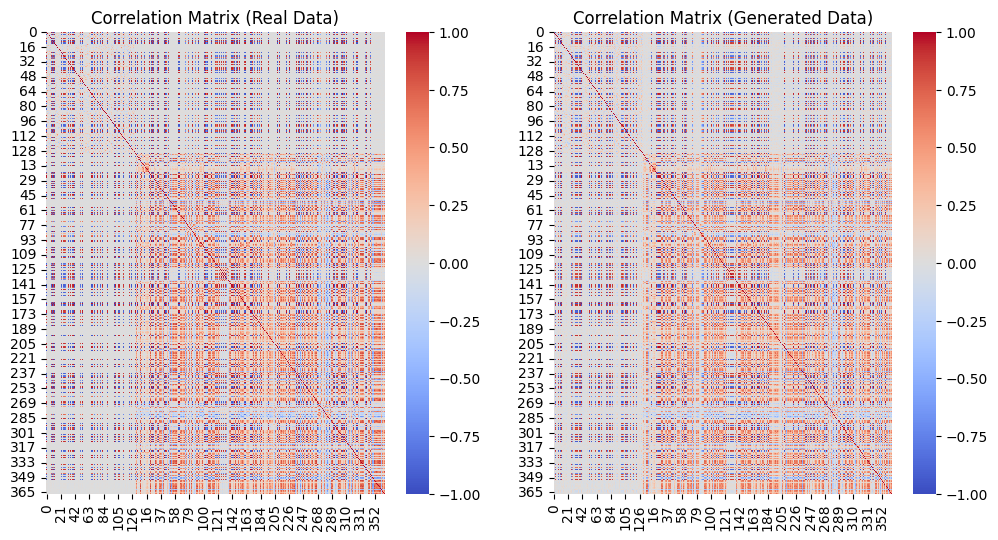

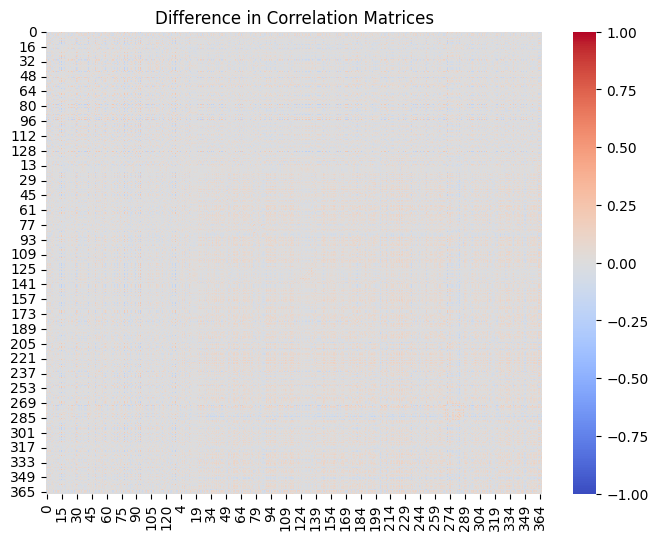

Accuracy: 0.7768333333333334

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.77      0.77      2983
           1       0.77      0.79      0.78      3017

    accuracy                           0.78      6000
   macro avg       0.78      0.78      0.78      6000
weighted avg       0.78      0.78      0.78      6000



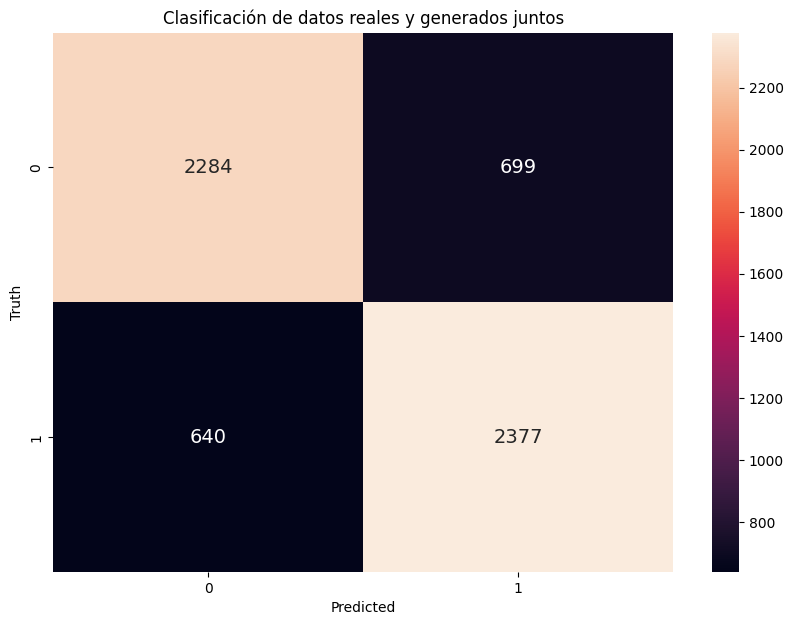

              precision    recall  f1-score   support

           0       0.84      1.00      0.91      1904
           1       0.99      0.66      0.79      1096

    accuracy                           0.87      3000
   macro avg       0.91      0.83      0.85      3000
weighted avg       0.89      0.87      0.87      3000



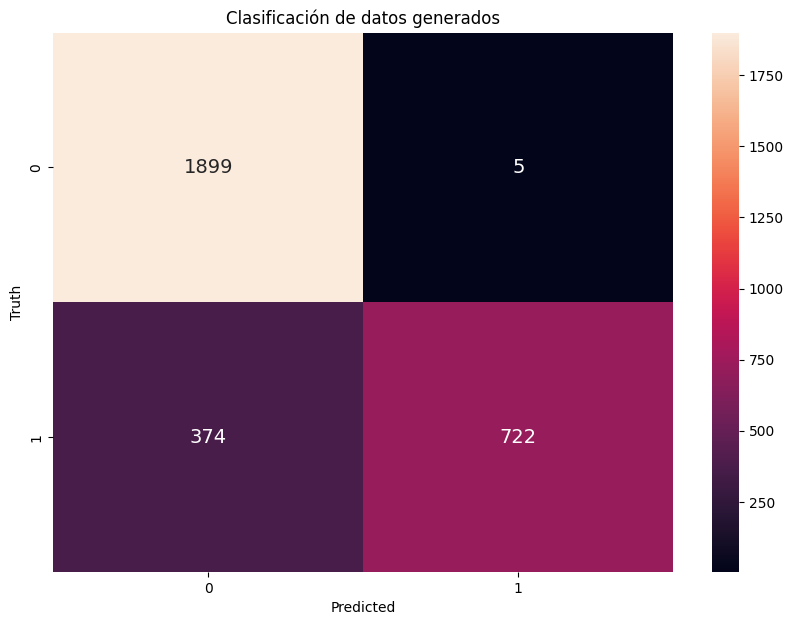

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      2370
           2       1.00      1.00      1.00       630

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



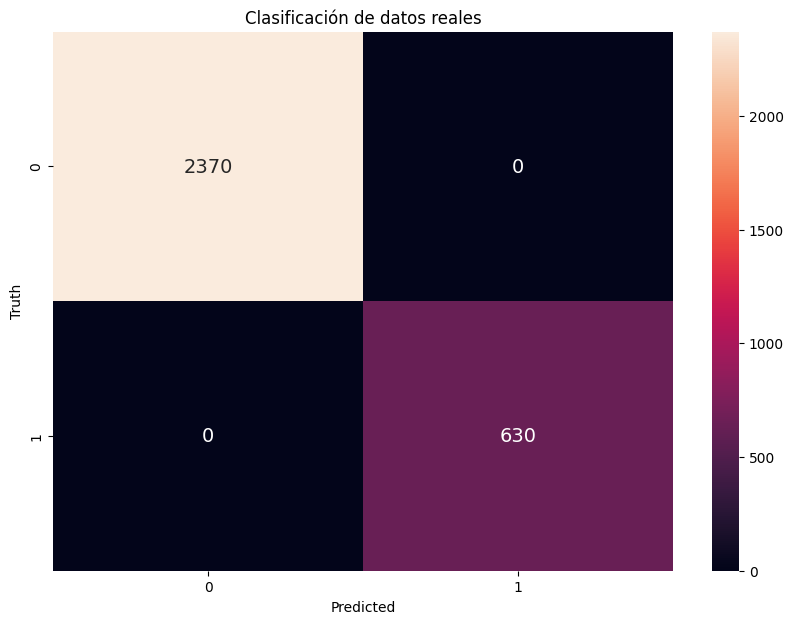

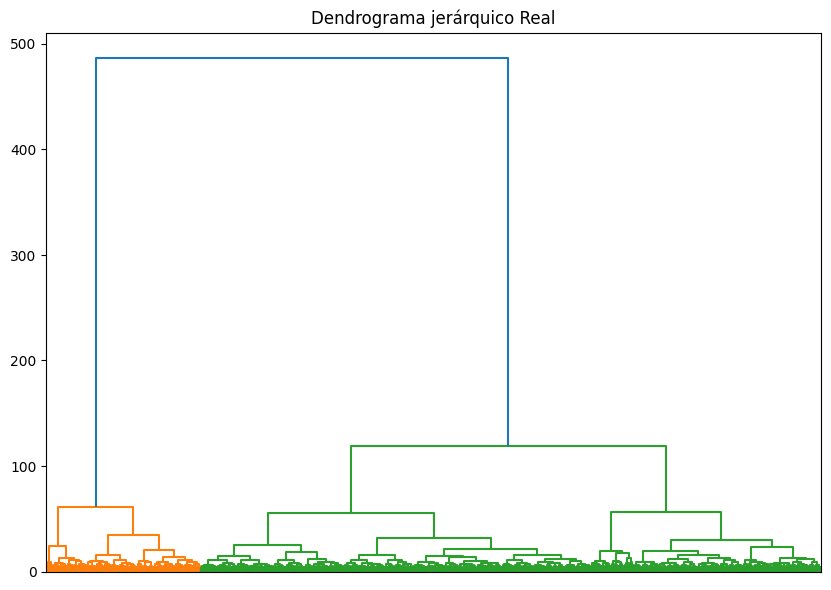

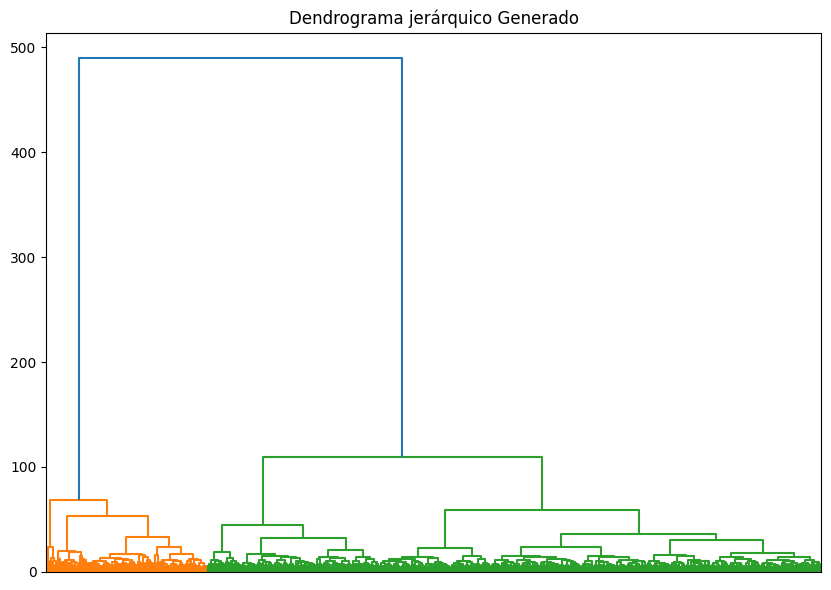

/home/fede/PyEnv/PB/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


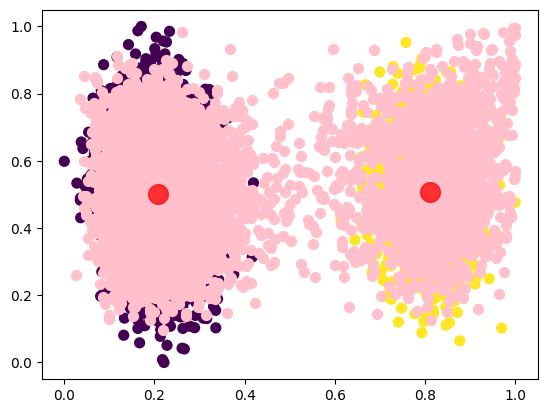

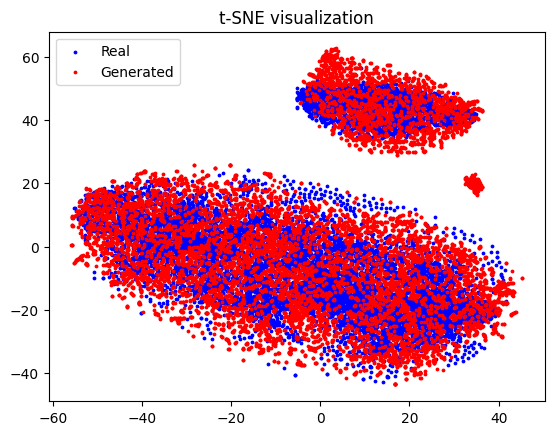

/home/fede/PyEnv/PB/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


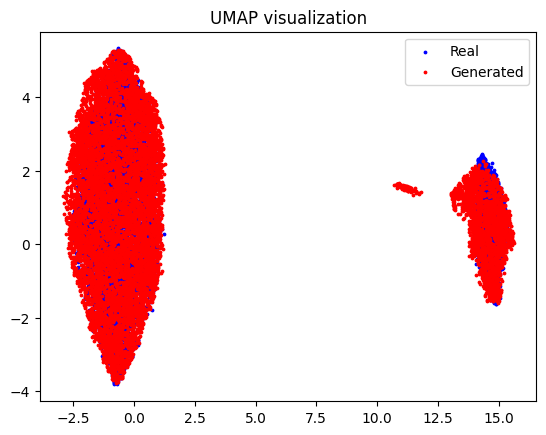

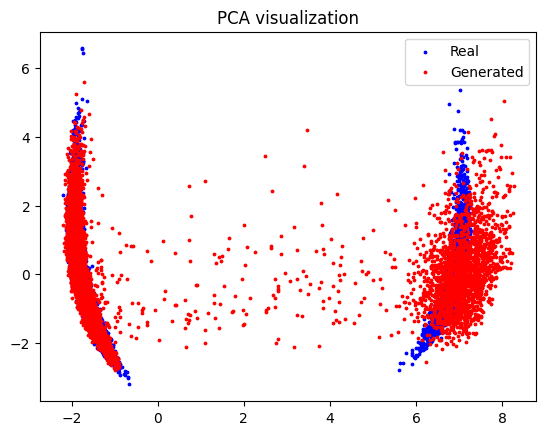

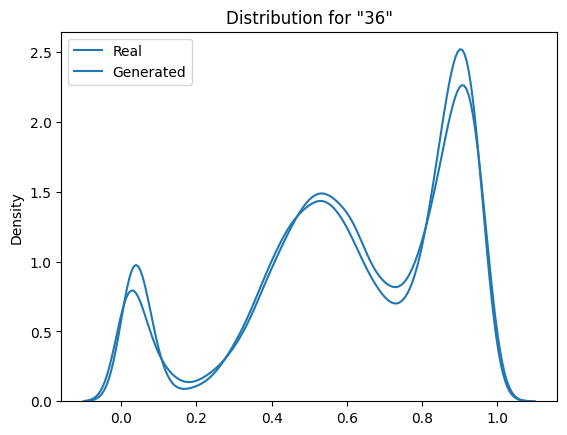

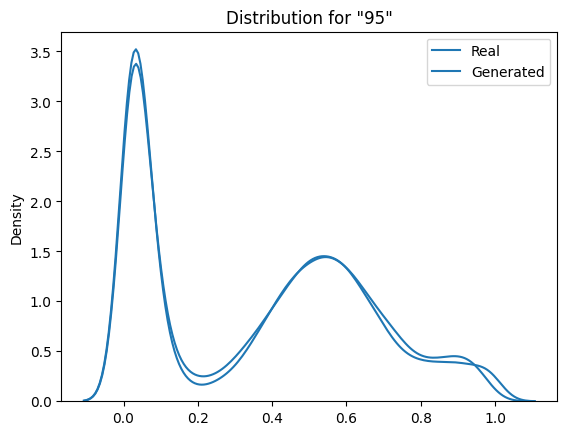

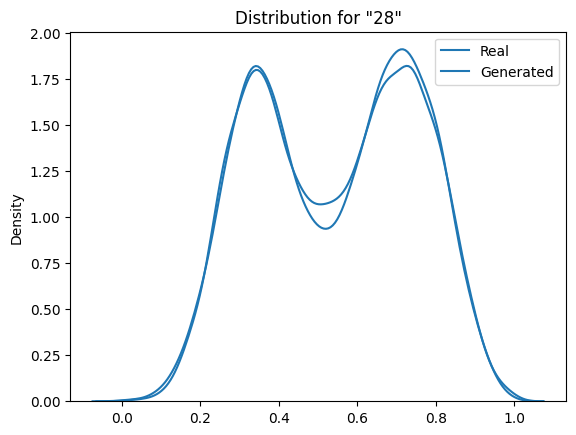

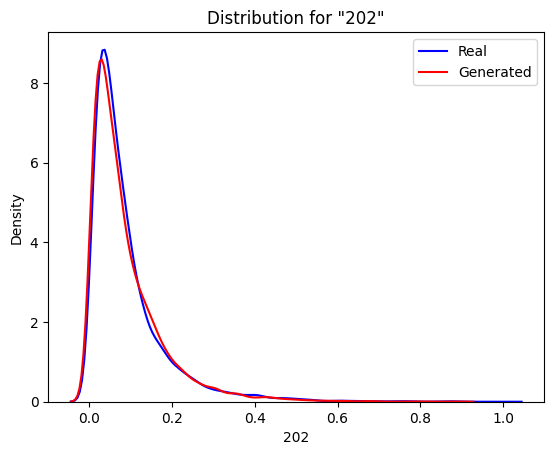

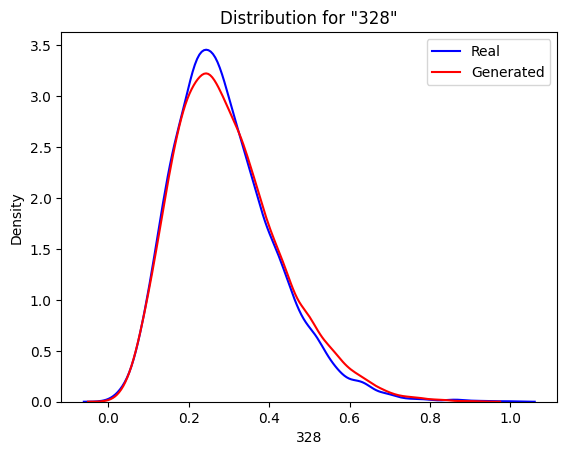

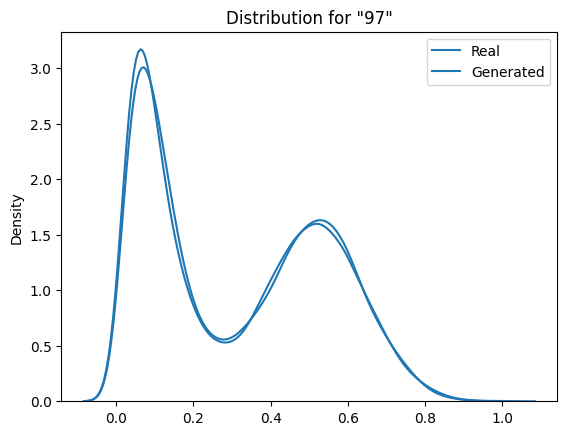

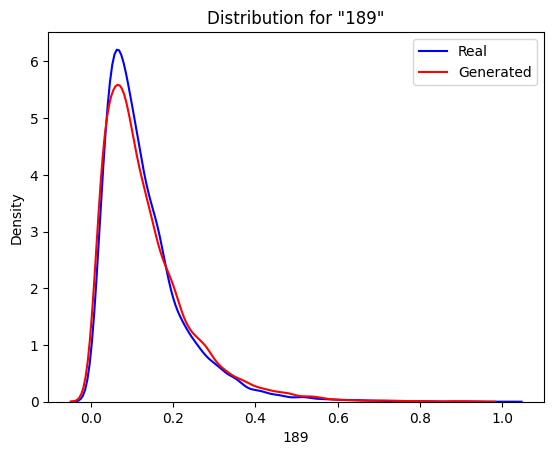

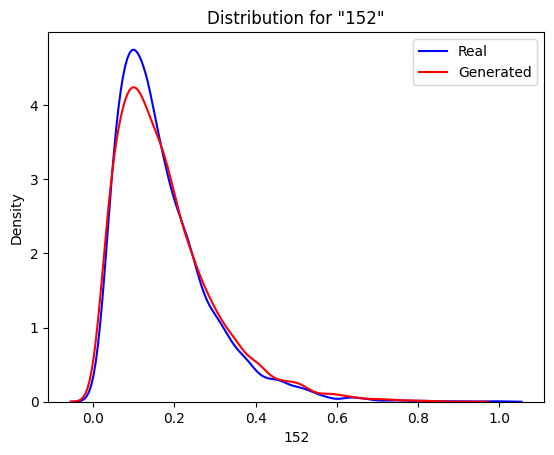

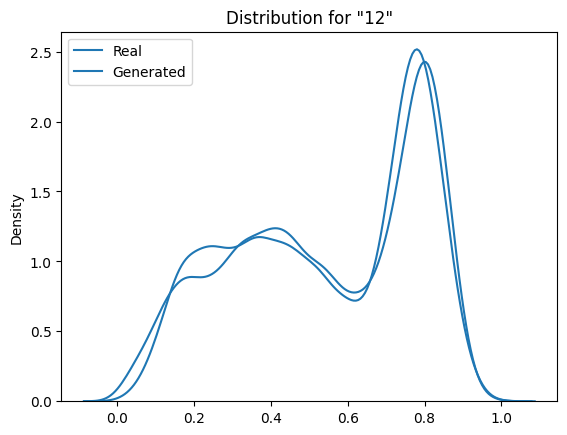

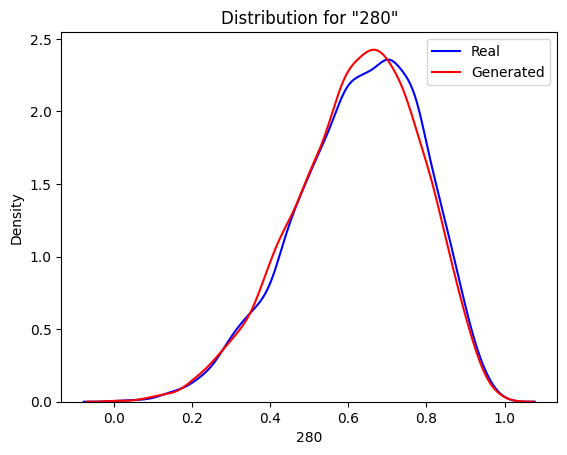

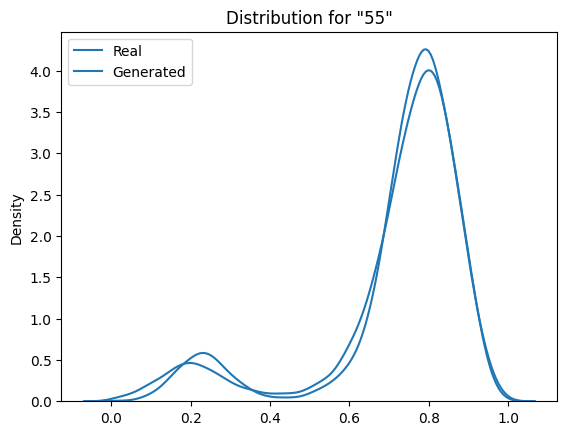

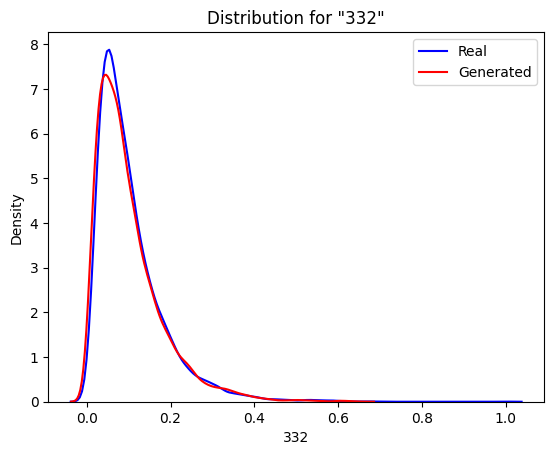

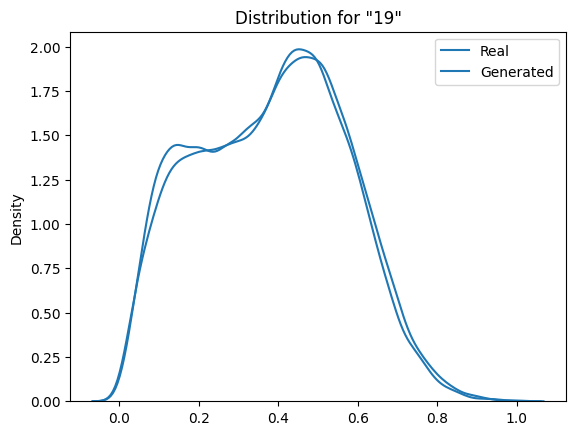

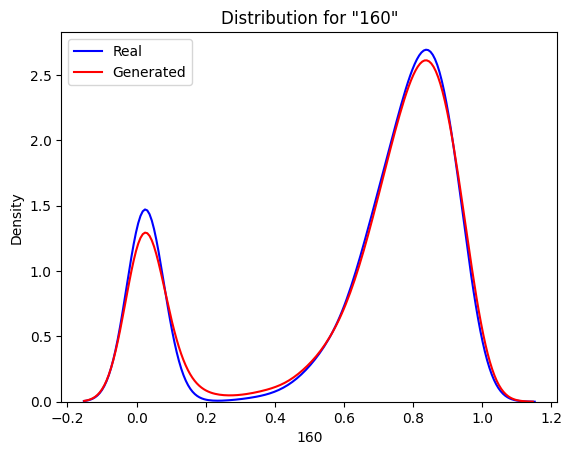

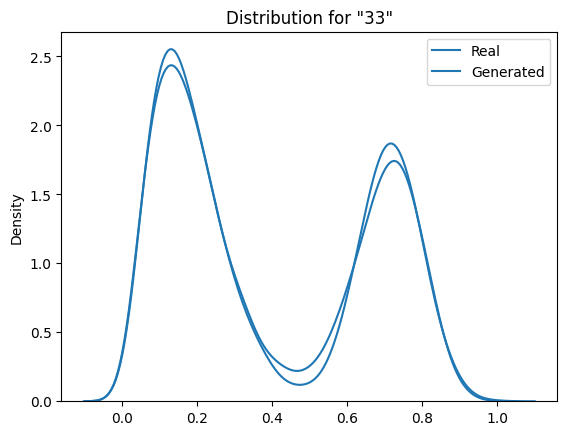

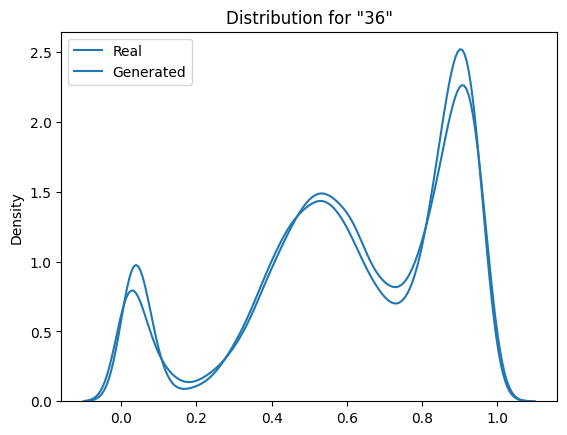

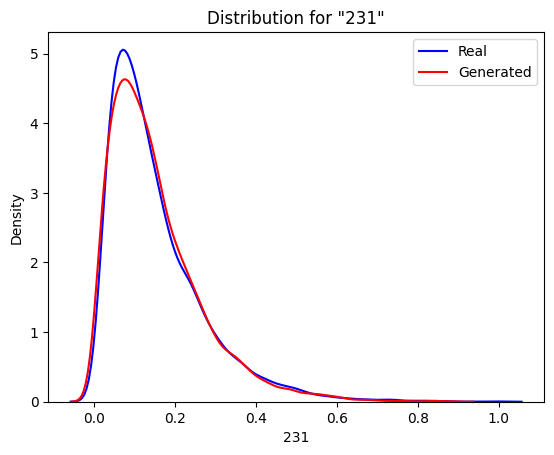

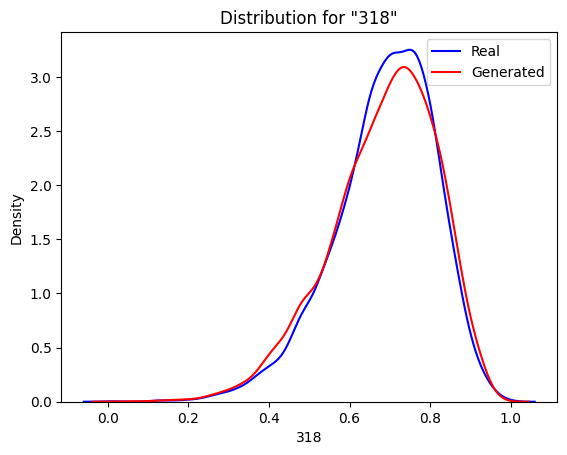

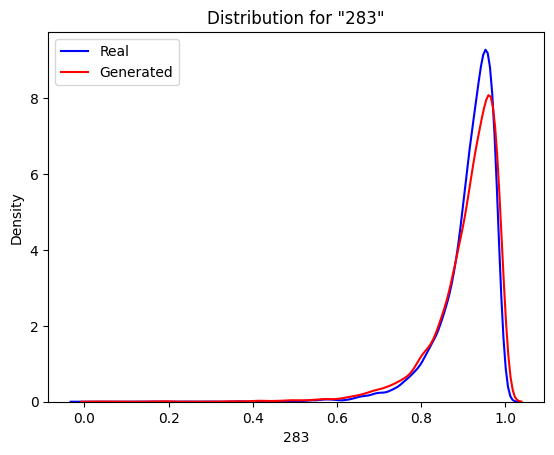

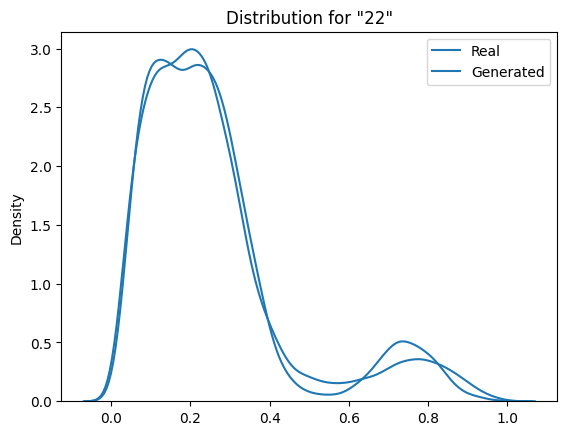

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import umap

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from scipy.stats import wasserstein_distance, ks_2samp
import sys
sys.setrecursionlimit(20000)

# Cargamos los datos
expr_data = pd.read_csv(fnexpr)
meth_data = pd.read_csv(fnmet)
assig_data = pd.read_csv(fnassig)
expr_data = expr_data.iloc[:, 1:]
meth_data = meth_data.iloc[:, 1:]
assig_data = assig_data.iloc[:, 2:]

# Convertir todas las columnas a tipo float
expr_data = expr_data.apply(pd.to_numeric, errors='coerce')
meth_data = meth_data.apply(pd.to_numeric, errors='coerce')
assig_data = assig_data.apply(pd.to_numeric, errors='coerce')

# Lidiar con valores NaN (si los hay). Pone 0 (CAMBIAR)
#expr_data.fillna(0, inplace=True)
#meth_data.fillna(0, inplace=True)
#assig_data.fillna(0, inplace=True)

#Normalizamos
expr_data = scaler.fit_transform(expr_data)
meth_data = scaler.fit_transform(meth_data)
expr_data = pd.DataFrame(expr_data)
meth_data = pd.DataFrame(meth_data)
assig_data = pd.DataFrame(assig_data)

# Combinamos los datos de expresión génica y metilación
X_real = pd.concat([expr_data, meth_data], axis=1)


# Generar datos de expresión sintética
gen2 = Generator(100, expression_data.shape[1]+methylation_data.shape[1]+assign_data.shape[1]).to(device)
gen2.load_state_dict(torch.load(fnmodel))
gen2.eval()
expressions_list = []
for i in range(nsamp):
    noise = torch.randn(1, 100).to(device)
    synthetic_expression = gen2(noise).to(device)
    #print(synthetic_expression)
    expressions_list.append(synthetic_expression.detach().cpu().numpy().squeeze())

X_gan = pd.DataFrame(expressions_list)

y = X_gan.iloc[:, -1].values.astype(int)  # Suponiendo que la asignación está en la primera columna

X = X_gan.iloc[:, :-1]

last_column = X_gan.columns[-1]
X_gan = X_gan.drop(columns=[last_column])
X_gan.columns = X_real.columns
# Concatena los datos reales con los generados
X_combined = np.vstack([X_real, X_gan])


# Aplanar los datos para cálculos estadísticos
real_data_flattened = X_real.values.flatten()
generated_data_flattened = X_gan.values.flatten()

# Wasserstein Distance
w_distance = wasserstein_distance(real_data_flattened, generated_data_flattened)

# KS Test y Wassertein Distance
ks_statistic, ks_pvalue = ks_2samp(real_data_flattened, generated_data_flattened)

print(f"Wasserstein Distance: {w_distance}")
print(f"KS Statistic: {ks_statistic}, P-Value: {ks_pvalue}")


# Distancia Euclidiana
distancias_euclidianas = cdist(X_real, X_gan, metric='euclidean')
distancia_promedio_euclidiana = np.mean(distancias_euclidianas)
print("Distancia Euclidiana Promedio:", distancia_promedio_euclidiana)

# Calcula las matrices de correlación
corr_real = X_real.corr()
corr_gan = X_gan.corr()


# Dibuja las matrices de correlación
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.heatmap(corr_real, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix (Real Data)')

plt.subplot(1, 2, 2)
sns.heatmap(corr_gan, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix (Generated Data)')

plt.show()

# Calcula la matriz de diferencias
corr_diff = corr_real - corr_gan

# Dibuja la matriz de diferencias
plt.figure(figsize=(8, 6))
sns.heatmap(corr_diff, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Difference in Correlation Matrices')
plt.show()

# Etiquetas: 1 para real, 0 para generado
y_real = [1] * X_real.shape[0]
y_gan = [0] * X_gan.shape[0]

# Combina los datos y las etiquetas
y_combined = y_real + y_gan

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.3, random_state=42)

# Inicializa y entrena el clasificador SVC
svc = SVC()
svc.fit(X_train, y_train)

# Realiza predicciones en el conjunto de prueba
y_pred = svc.predict(X_test)
# Evalúa el rendimiento del clasificador
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g',annot_kws={"size": 14})
plt.title('Clasificación de datos reales y generados juntos')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.savefig(filename+"SVC1.jpg")
plt.show()


# Dividimos los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entrenamos el modelo SVC
clf = SVC()
unique_classes = np.unique(y_train)
if len(unique_classes) > 1:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='g',annot_kws={"size": 14})
    plt.xlabel('Predicted')
    plt.title('Clasificación de datos generados')
    plt.ylabel('Truth')
    plt.savefig(filename+"SVC2.jpg")
    plt.show()
else:
    print("SVC: Solo una clase")

# Combinamos los datos de expresión génica y metilación
X2 = pd.concat([expr_data, meth_data], axis=1)
y2 = assig_data.iloc[:, 0].values  # Suponiendo que la asignación está en la primera columna

# Dividimos los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.3, random_state=42)

# Entrenamos el modelo SVC
clf = SVC()
clf.fit(X_train, y_train)

# Predicciones
y_pred = clf.predict(X_test)

# Métricas de clasificación
print(classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g',annot_kws={"size": 14})
plt.xlabel('Predicted')
plt.title('Clasificación de datos reales')
plt.ylabel('Truth')
plt.show()


# Clustering jerárquico
linked1 = linkage(X_real, method='ward')
linked2 = linkage(X_gan, method='ward')

plt.figure(figsize=(10, 7))
dendrogram(linked1, orientation='top', no_labels=True)
plt.title("Dendrograma jerárquico Real")
plt.savefig(filename+"DJR.jpg")
plt.show()

plt.figure(figsize=(10, 7))
dendrogram(linked2, orientation='top', no_labels=True)
plt.title("Dendrograma jerárquico Generado")
plt.savefig(filename+"DJG.jpg")
plt.show()


# K-Means
k = 2
kmeans = KMeans(n_clusters=k)
kmeans.fit(X_real)
labels = kmeans.predict(X_real)
centroids = kmeans.cluster_centers_
X_array = X_real.values
generated_data=X_gan.values
plt.scatter(X_array[:, 0], X_array[:, 1], c=labels, s=50, cmap='viridis')
plt.scatter(generated_data[:, 0], generated_data[:, 1], s=50, color='pink', label='Datos Generados')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, alpha=0.75)
plt.savefig(filename+"KNN.jpg")
plt.show()

# Aplicar t-SNE
# Crea etiquetas para los datos (1 para reales, 0 para GAN)
labels = np.concatenate([np.ones(X_real.shape[0]), np.zeros(X_gan.shape[0])])
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_combined)

plt.scatter(X_tsne[labels==1, 0], X_tsne[labels==1, 1], c='blue', label='Real', s=3)
plt.scatter(X_tsne[labels==0, 0], X_tsne[labels==0, 1], c='red', label='Generated', s=3)
plt.legend()
plt.title('t-SNE visualization')
plt.savefig(filename+"tsne.jpg")
plt.show()

# Configurando y entrenando UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_combined)

# Dibujando la visualización
plt.scatter(X_umap[labels==1, 0], X_umap[labels==1, 1], c='blue', label='Real', s=3)
plt.scatter(X_umap[labels==0, 0], X_umap[labels==0, 1], c='red', label='Generated', s=3)
plt.legend()
plt.title('UMAP visualization')
plt.savefig(filename+"umap.jpg")
plt.show()

#PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_combined)

plt.scatter(X_pca[labels==1, 0], X_pca[labels==1, 1], c='blue', label='Real', s=3)
plt.scatter(X_pca[labels==0, 0], X_pca[labels==0, 1], c='red', label='Generated', s=3)
plt.legend()
plt.title('PCA visualization')
plt.savefig(filename+"pca.jpg")
plt.show()

#KDE
column_names = X_real.columns.tolist()
random_columns = random.sample(column_names, 20)
for column_name in random_columns:
    sns.kdeplot(X_real[column_name], label='Real',color='blue')
    sns.kdeplot(X_gan[column_name], label='Generated',color='red')
    plt.legend()
    plt.title(f'Distribution for "{column_name}"')
    plt.savefig(f"{filename}kde-{column_name}.jpg")
    plt.show()

Descripción de los datos de expresión génica:
                0             1             2             3             4    \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       0.328066      0.503368      0.659170      0.507475      0.491423   
std        0.247159      0.135970      0.218681      0.134313      0.129720   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.181019      0.411101      0.660420      0.415131      0.405544   
50%        0.223655      0.502669      0.741512      0.506127      0.491109   
75%        0.287407      0.595957      0.795608      0.599708      0.577160   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                5             6             7             8             9    \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       0.515437      0.538387      0.372585      0.477964      0.688998   
std  

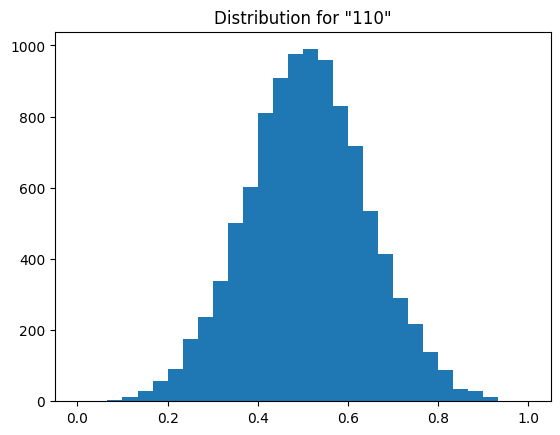

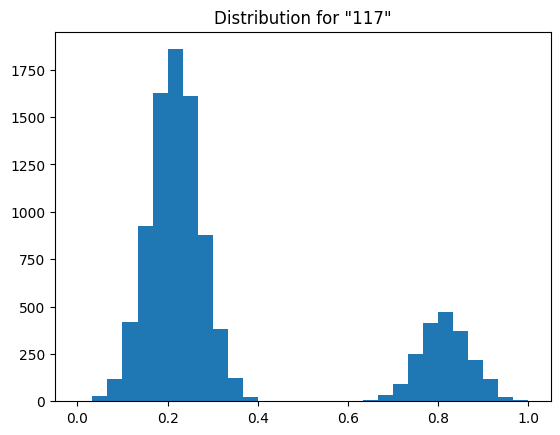

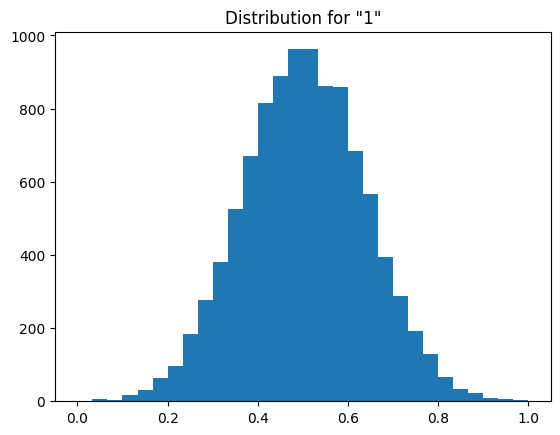

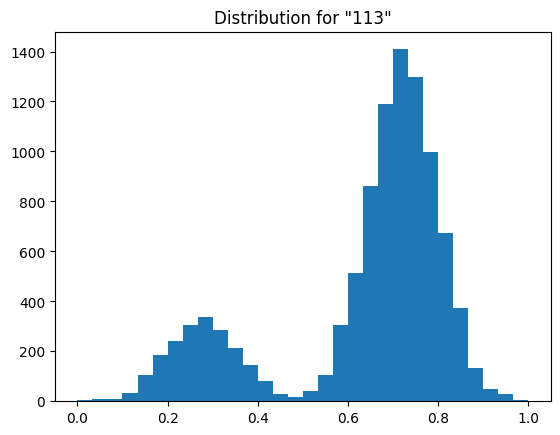

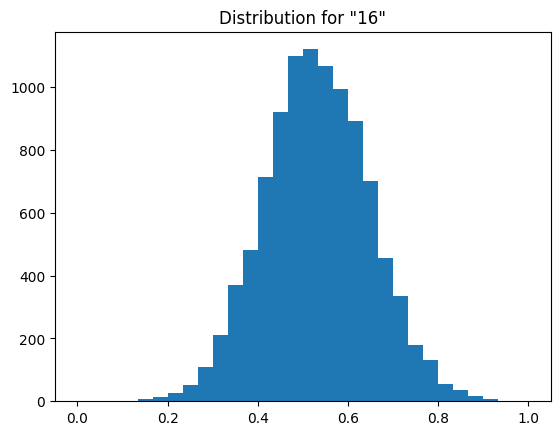

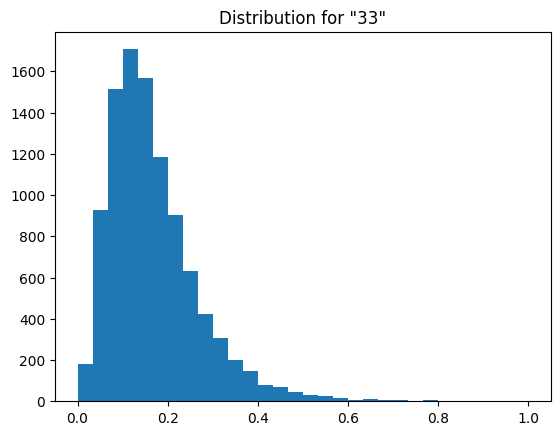

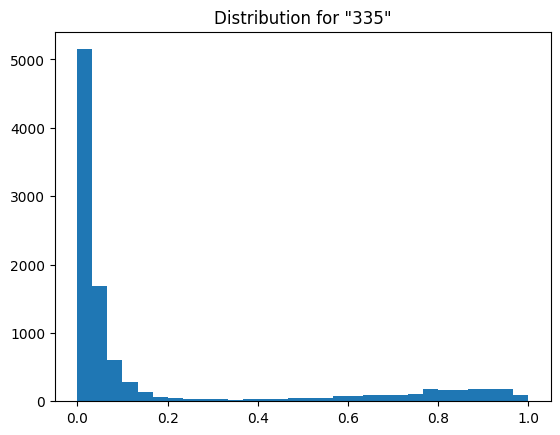

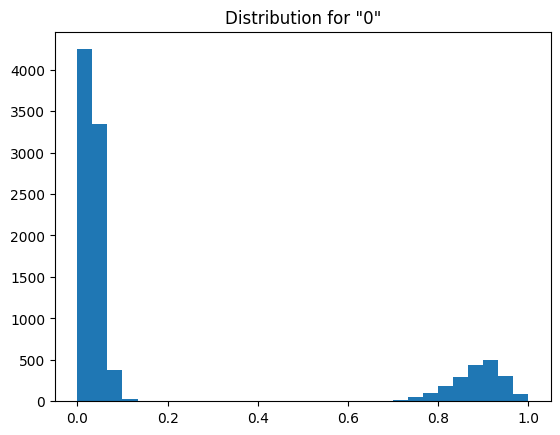

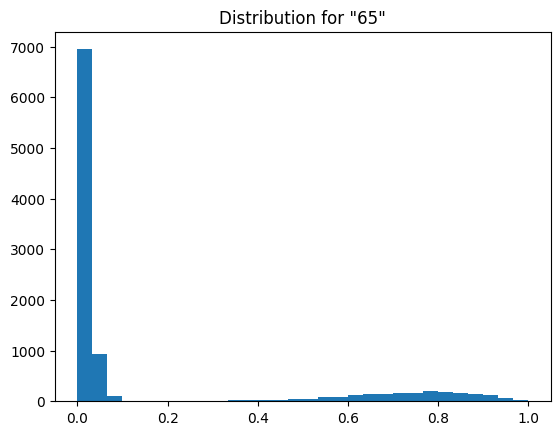

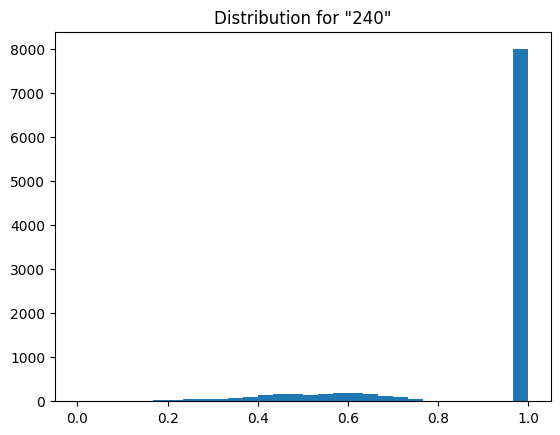

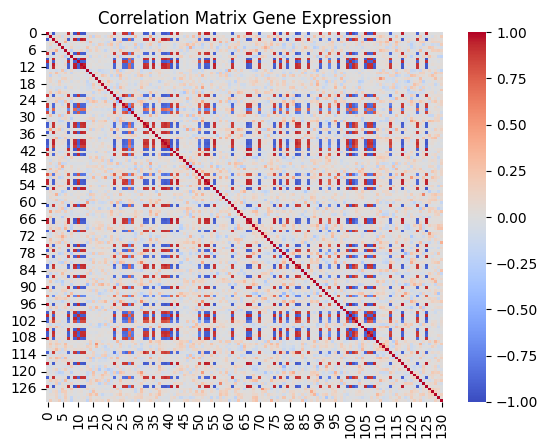

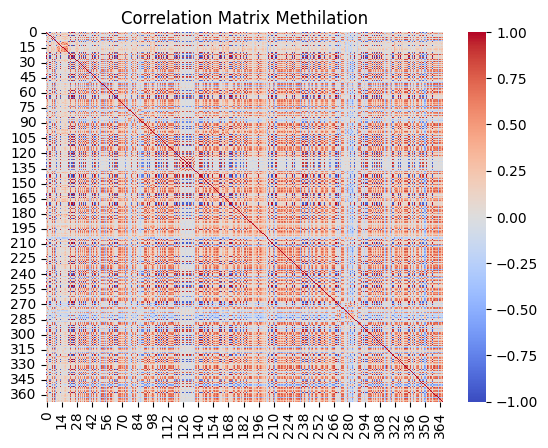

Matriz de Covarianza:
          0         1         2         3         4         5         6    \
0    0.061088 -0.000020 -0.050650 -0.000658 -0.000199 -0.000251 -0.000640   
1   -0.000020  0.018488 -0.000694  0.001251  0.002205 -0.002198  0.001433   
2   -0.050650 -0.000694  0.047822  0.003394 -0.000030  0.000385  0.003421   
3   -0.000658  0.001251  0.003394  0.018040 -0.001045  0.000564  0.006205   
4   -0.000199  0.002205 -0.000030 -0.001045  0.016827  0.000500 -0.001365   
..        ...       ...       ...       ...       ...       ...       ...   
362 -0.000053  0.000053  0.000099  0.000101  0.000049 -0.000178 -0.000055   
363 -0.000021  0.000163 -0.000021 -0.000157  0.000058  0.000235  0.000195   
364 -0.000035  0.000234 -0.000004 -0.000129  0.000118  0.000123  0.000214   
365 -0.000275  0.000218  0.000195 -0.000057 -0.000087 -0.000041 -0.000071   
366  0.000414  0.000031 -0.000414 -0.000060 -0.000136  0.000033  0.000106   

          7         8         9    ...       357     

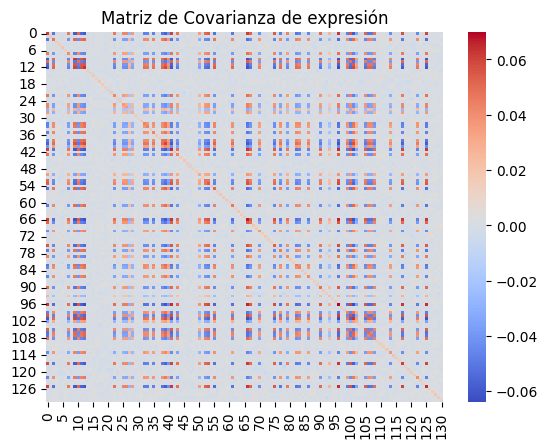

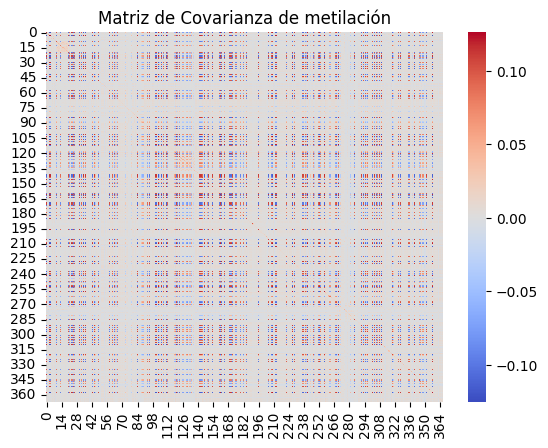

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import umap

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from scipy.stats import wasserstein_distance, ks_2samp
import sys
sys.setrecursionlimit(20000)
fnexpr='exprLOW.csv'
fnmet='methylLOW.csv'
fnassig='assignLOW.csv'
# Cargamos los datos
expr_data = pd.read_csv(fnexpr)
meth_data = pd.read_csv(fnmet)
assig_data = pd.read_csv(fnassig)
expr_data = expr_data.iloc[:, 1:]
meth_data = meth_data.iloc[:, 1:]
assig_data = assig_data.iloc[:, 2:]

# Convertir todas las columnas a tipo float
expr_data = expr_data.apply(pd.to_numeric, errors='coerce')
meth_data = meth_data.apply(pd.to_numeric, errors='coerce')
assig_data = assig_data.apply(pd.to_numeric, errors='coerce')

# Lidiar con valores NaN (si los hay). Pone 0 (CAMBIAR)
#expr_data.fillna(0, inplace=True)
#meth_data.fillna(0, inplace=True)
#assig_data.fillna(0, inplace=True)

#Normalizamos
expr_data = scaler.fit_transform(expr_data)
meth_data = scaler.fit_transform(meth_data)
expr_data = pd.DataFrame(expr_data)
meth_data = pd.DataFrame(meth_data)
assig_data = pd.DataFrame(assig_data)

# Combinamos los datos de expresión génica y metilación
X_real = pd.concat([expr_data, meth_data], axis=1)

# Realizar análisis estadísticos básicos
# Por ejemplo, describir los datos
descripcion_expresion = expr_data.describe()
descripcion_metilacion = meth_data.describe()

# Imprimir las descripciones

print("Descripción de los datos de expresión génica:")
print(descripcion_expresion)
print("\nDescripción de los datos de metilación:")
print(descripcion_metilacion)

column_names = expr_data.columns.tolist()
random_columns = random.sample(column_names, 5)
for column_name in random_columns:
    plt.hist(expr_data[column_name], bins=30)
    plt.title(f'Distribution for "{column_name}"')
    plt.savefig(f"expr-{column_name}.jpg")
    plt.show() 

column_names = meth_data.columns.tolist()
random_columns = random.sample(column_names, 5)
for column_name in random_columns:
    plt.hist(meth_data[column_name], bins=30)
    plt.title(f'Distribution for "{column_name}"')
    plt.savefig(f"meth-{column_name}.jpg")
    plt.show()   
# Calcula las matrices de correlación
corr_real = X_real.corr()
corr_expr = expr_data.corr()
corr_meth = meth_data.corr()


# Dibuja las matrices de correlación
sns.heatmap(corr_expr, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Gene Expression')
plt.savefig("CorrExpr")
plt.show()
sns.heatmap(corr_meth, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Methilation')
plt.savefig("CorrMeth")
plt.show()




# Calculando la matriz de covarianza
cov_matrix = X_real.cov()
cov_expr = expr_data.cov()
cov_meth = meth_data.cov()
# Mostrando la matriz de covarianza
print("Matriz de Covarianza:")
print(cov_matrix)

# Visualizando la matriz de covarianza
sns.heatmap(cov_expr, cmap='coolwarm',  fmt='g')
plt.title("Matriz de Covarianza de expresión")
plt.savefig("CovExpr")
plt.show()
sns.heatmap(cov_meth, cmap='coolwarm',  fmt='g')
plt.title("Matriz de Covarianza de metilación")
plt.savefig("CovMeth")
plt.show()





Descripción de los datos de expresión génica:
gene   ERCC-00098  ERCC-00095  ERCC-00077  ERCC-00126     TRIM44   C15orf39  \
count   37.000000   37.000000   37.000000   37.000000  37.000000  37.000000   
mean     0.274743    0.400184    0.620007    0.444825   0.683416   0.375251   
std      0.215829    0.264651    0.188099    0.232822   0.198297   0.205616   
min      0.000000    0.000000    0.000000    0.000000   0.000000   0.000000   
25%      0.115098    0.161156    0.552205    0.272242   0.559708   0.274592   
50%      0.236963    0.346549    0.629690    0.390928   0.729935   0.366070   
75%      0.372541    0.635638    0.745447    0.599998   0.808248   0.497167   
max      1.000000    1.000000    1.000000    1.000000   1.000000   1.000000   

gene     PCDHGA9   STAMBPL1    MGC3771  LOC100130872  ...    SNORA33  \
count  37.000000  37.000000  37.000000     37.000000  ...  37.000000   
mean    0.319649   0.636231   0.387641      0.356318  ...   0.395264   
std     0.188954   0.24854

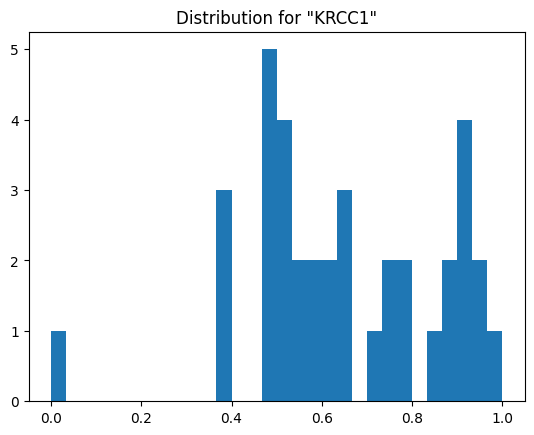

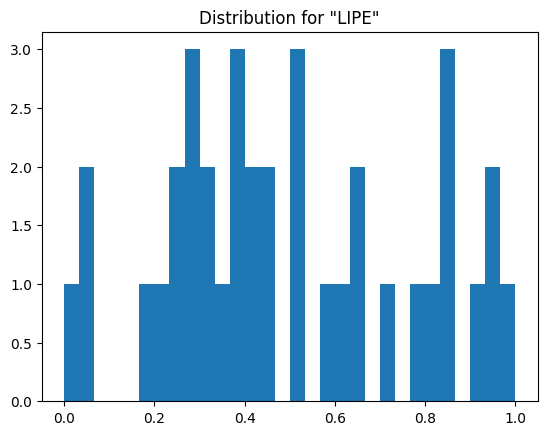

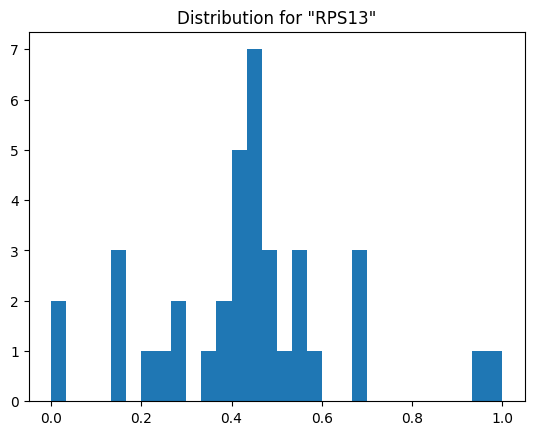

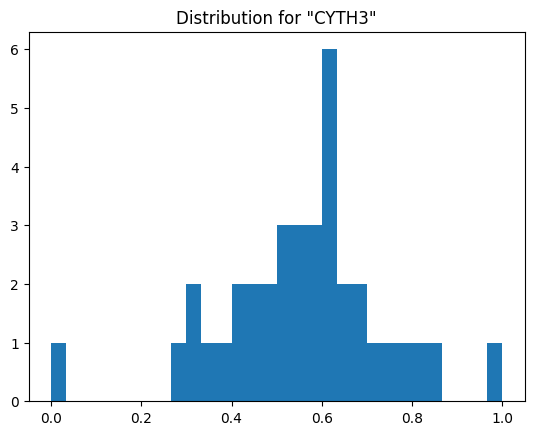

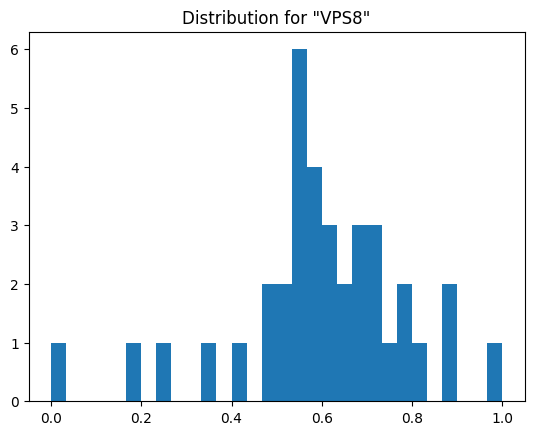

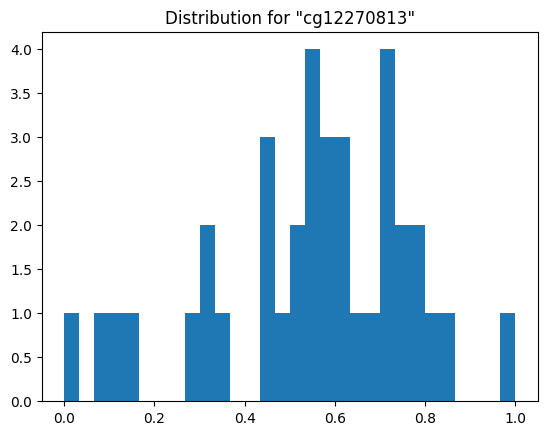

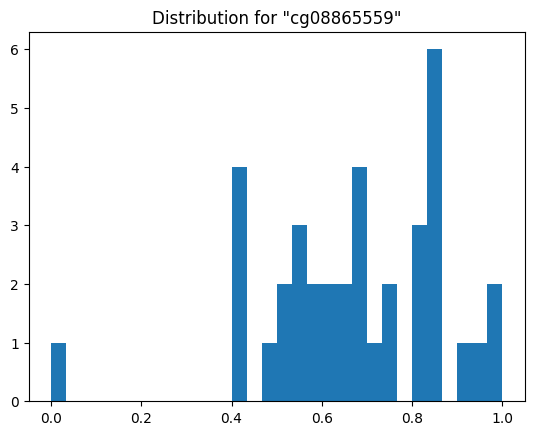

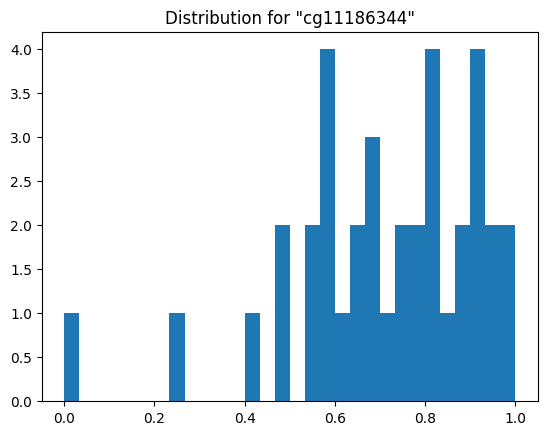

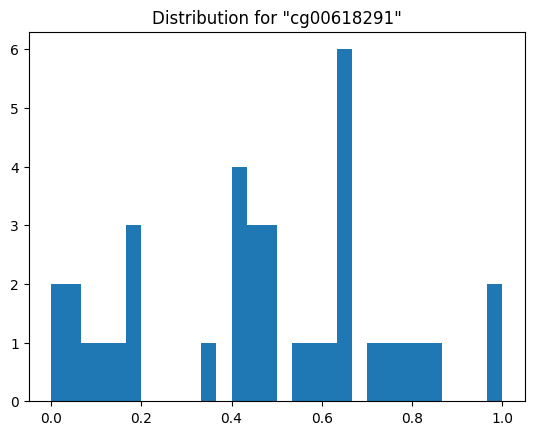

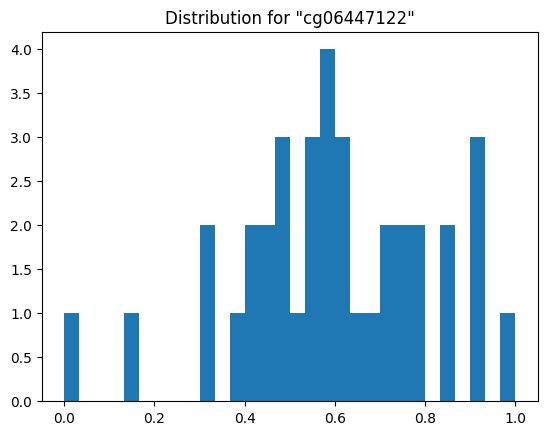

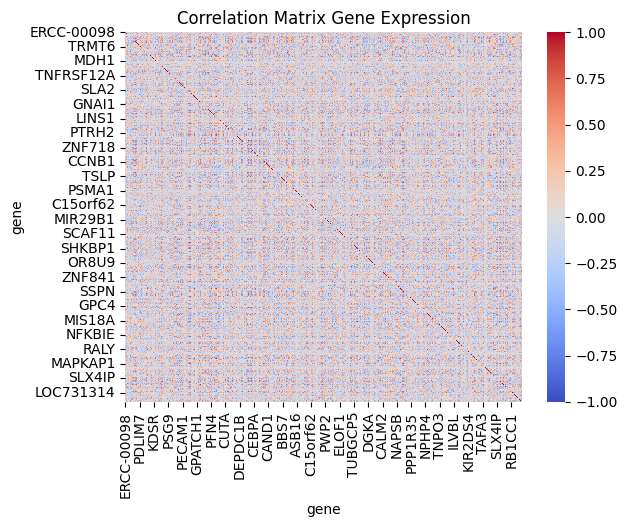

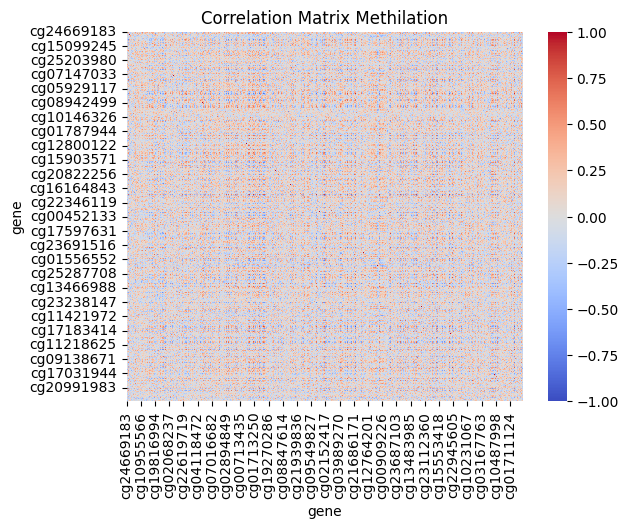

Matriz de Covarianza:
gene        ERCC-00098  ERCC-00095  ERCC-00077  ERCC-00126    TRIM44  \
gene                                                                   
ERCC-00098    0.046582   -0.003502    0.007791   -0.018488 -0.002647   
ERCC-00095   -0.003502    0.070040    0.006842   -0.005661  0.005888   
ERCC-00077    0.007791    0.006842    0.035381    0.009619  0.005514   
ERCC-00126   -0.018488   -0.005661    0.009619    0.054206 -0.004341   
TRIM44       -0.002647    0.005888    0.005514   -0.004341  0.039322   
...                ...         ...         ...         ...       ...   
cg22359362    0.004050   -0.002084   -0.000621    0.001734 -0.000599   
cg11422402    0.004713   -0.010694    0.000601    0.003453 -0.000515   
cg09477198    0.005987   -0.000858    0.002998    0.008389 -0.006401   
cg24044651   -0.016458   -0.000479   -0.006148    0.006828  0.011582   
cg04667458   -0.006533    0.013812   -0.009930    0.004440  0.005887   

gene        C15orf39   PCDHGA9  STAMBPL1 

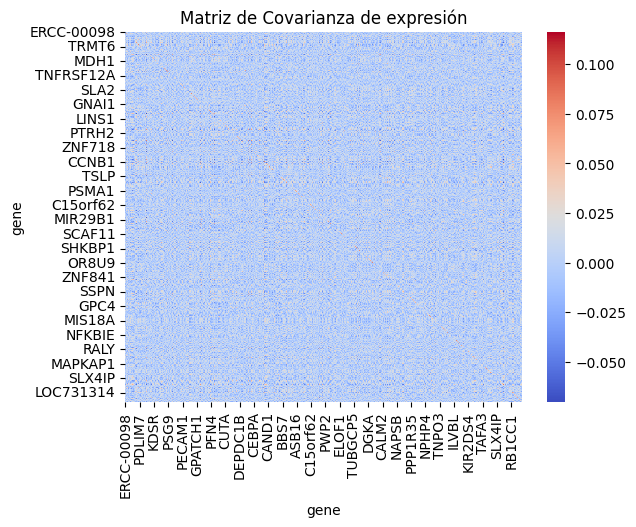

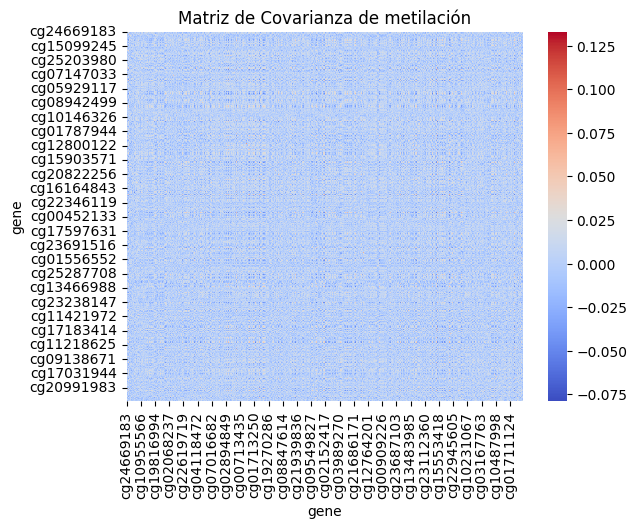

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import umap

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from scipy.stats import wasserstein_distance, ks_2samp
import sys
from sklearn.preprocessing import StandardScaler,MinMaxScaler

sys.setrecursionlimit(20000)
fnexpr='GSE117931/GSE117931_GPL14951.tsv'
fnmet='GSE117931/GSE117931_GPL13534.tsv'
fnassig='GSE117931/assig.csv'
# Leer datos
expression_data = pd.read_csv(fnexpr,sep='\t', index_col=0)
expression_data=expression_data.T
methylation_data = pd.read_csv(fnmet,sep='\t', index_col=0)
methylation_data=methylation_data.T
assign_data = pd.read_csv(fnassig,sep='\t')

expression_data = expression_data.iloc[:, 1:]
methylation_data = methylation_data.iloc[:, 1:]
assign_data = assign_data.iloc[:, 1:]

# Convertir todas las columnas a tipo float
expression_data = expression_data.apply(pd.to_numeric, errors='coerce')
methylation_data = methylation_data.apply(pd.to_numeric, errors='coerce')
assign_data = assign_data.apply(pd.to_numeric, errors='coerce')

# Lidiar con valores NaN (si los hay). 
methylation_data.dropna(axis=1, inplace=True)
#expression_data.fillna(0, inplace=True)
#methylation_data.fillna(0, inplace=True)
#assign_data.fillna(0, inplace=True)

#Normalizamos
scaler = MinMaxScaler()

# Asumiendo que expression_data, methylation_data y assign_data son tus DataFrames
expression_data_scaled = scaler.fit_transform(expression_data)
methylation_data_scaled = scaler.fit_transform(methylation_data)
assign_data_scaled =assign_data

# Convertir a DataFrame
expr_data = pd.DataFrame(expression_data_scaled, index=expression_data.index, columns=expression_data.columns)
meth_data = pd.DataFrame(methylation_data_scaled, index=methylation_data.index, columns=methylation_data.columns)
assign_data = pd.DataFrame(assign_data_scaled, index=assign_data.index, columns=assign_data.columns)

expr_data = expr_data.iloc[:, :1000]
meth_data = meth_data.iloc[:, :10000]

# Combinamos los datos de expresión génica y metilación
X_real = pd.concat([expr_data, meth_data], axis=1)

# Realizar análisis estadísticos básicos
# Por ejemplo, describir los datos
descripcion_expresion = expr_data.describe()
descripcion_metilacion = meth_data.describe()

# Imprimir las descripciones

print("Descripción de los datos de expresión génica:")
print(descripcion_expresion)
print("\nDescripción de los datos de metilación:")
print(descripcion_metilacion)

column_names = expr_data.columns.tolist()
random_columns = random.sample(column_names, 5)
for column_name in random_columns:
    plt.hist(expr_data[column_name], bins=30)
    plt.title(f'Distribution for "{column_name}"')
    plt.savefig(f"expr-{column_name}.jpg")
    plt.show() 

column_names = meth_data.columns.tolist()
random_columns = random.sample(column_names, 5)
for column_name in random_columns:
    plt.hist(meth_data[column_name], bins=30)
    plt.title(f'Distribution for "{column_name}"')
    plt.savefig(f"meth-{column_name}.jpg")
    plt.show()   
# Calcula las matrices de correlación
corr_real = X_real.corr()
corr_expr = expr_data.corr()
corr_meth = meth_data.corr()


# Dibuja las matrices de correlación
sns.heatmap(corr_expr, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Gene Expression')
plt.savefig("CorrExpr")
plt.show()
sns.heatmap(corr_meth, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Methilation')
plt.savefig("CorrMeth")
plt.show()




# Calculando la matriz de covarianza
cov_matrix = X_real.cov()
cov_expr = expr_data.cov()
cov_meth = meth_data.cov()
# Mostrando la matriz de covarianza
print("Matriz de Covarianza:")
print(cov_matrix)

# Visualizando la matriz de covarianza
sns.heatmap(cov_expr, cmap='coolwarm',  fmt='g')
plt.title("Matriz de Covarianza de expresión")
plt.savefig("CovExpr")
plt.show()
sns.heatmap(cov_meth, cmap='coolwarm',  fmt='g')
plt.title("Matriz de Covarianza de metilación")
plt.savefig("CovMeth")
plt.show()
